# SARIMAX and ARIMA forecasters

SARIMAX (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) is a generalization of the ARIMA model that  that takes into account both seasonality and exogenous variables. SARIMAX models are among the most used statistical models used for forecasting and their performance can be very hight.

A SARIMAX model is usually denoted $SARIMA(p,d,q)(P,D,Q)m$, where parameters $p$, $d$, and $q$ are non-negative integers, $p$ is the order (number of time lags) of the autoregressive model, $d$ is the degree of differencing (the number of times the data have had past values subtracted), and $q$ is the order of the moving-average model.  $m$ refers to the number of periods in each season, and the uppercase $P$, $D$, $Q$ refer to the autoregressive, differencing, and moving average terms for the seasonal part of the model.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

The class `ForecasterSarimax` allows to train and validate SARIMAX models from [pmdarima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA) (internally wraps the [statsmodels SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)) using the API of skforecast. Therefore making easy to compare its performance against other machine learning models.


## Libraries

In [22]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterSarimax import ForecasterSarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error

## Data

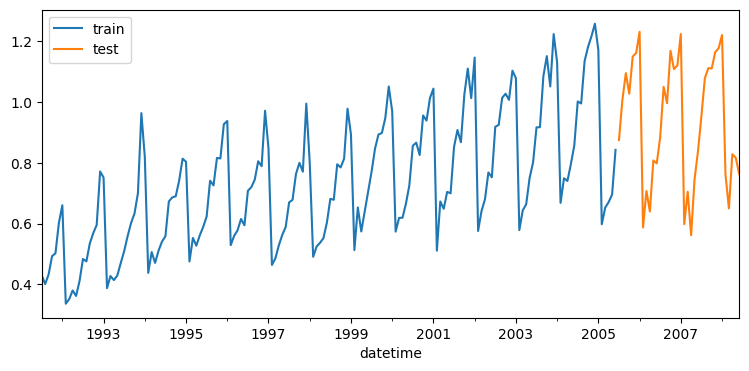

In [23]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [24]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = ARIMA(order=(12, 1, 1)),
             )

forecaster.fit(y=data_train)
forecaster

/home/ubuntu/anaconda3/envs/skforecast_py10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/skforecast_py10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': True} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2023-02-27 21:38:23 
Last fit date: 2023-02-27 21:38:25 
Index seen by the forecaster: DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2004-09-01', '2004-10-01', '2004

## Prediction

In [25]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.957064
2005-08-01    0.960572
2005-09-01    1.112108
Freq: MS, Name: pred, dtype: float64

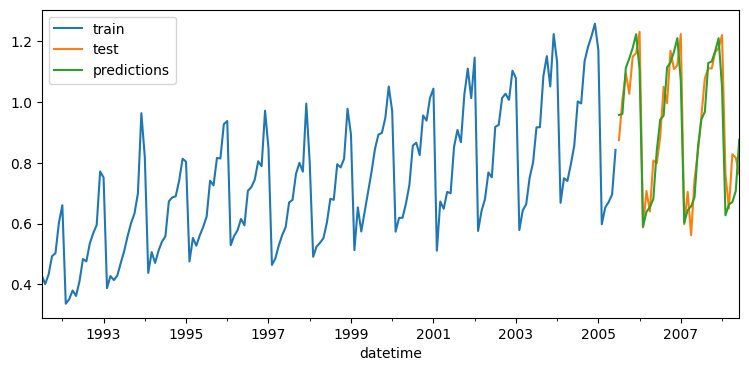

In [26]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [27]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.06867038884467447


## Prediction intervals

In [28]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95])
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.957064,0.858018,1.056111
2005-08-01,0.960572,0.855915,1.065228
2005-09-01,1.112108,1.003164,1.221053


## Feature importance

In [29]:
forecaster.get_feature_importance()

,feature,importance
0,intercept,0.001234
1,ar.L1,-0.016227
2,ar.L2,-0.046453
3,ar.L3,-0.011583
4,ar.L4,-0.066171
5,ar.L5,-0.029843
6,ar.L6,-0.025341
7,ar.L7,-0.069994
8,ar.L8,-0.009828
9,ar.L9,-0.035624


In [30]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>